# GPU

In [ ]:
# The GPU provided has 12GB of memory. However, sometimes the memory of your GPU is shared with other users. At that situation you won’t be able to train your model properly. 
# To make sure that the current GPU memory utilization is 0, run the code below:

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1933ed741549cc93495222025120a22c30f810c78fcc5939049653bad015edf5
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


IndexError: ignored

In [ ]:
# If the utilization is greater than 0% try to kill your machine, using the code below. This might not work on your first attempt and you can try this multiple times.

!kill -9 -1

In [ ]:
# Updating your data
# Once your Drive is mounted, any change to your drive directory (editing code, adding files, etc.) will not be encountered by Colab. This is due to Colab caching mechanism. 
# To overcome this, you should clear the cache before using your new files, using:

!google-drive-ocamlfuse -cc

/bin/bash: google-drive-ocamlfuse: command not found


# LRFinder definition

code source: https://github.com/titu1994/keras-one-cycle

In [ ]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = batch_size
        self.samples = num_samples
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        self.epochs = self.params['epochs']
        # When fit generator is used
        # self.params don't have the elements 'batch_size' and 'samples'
        # self.batch_size = self.params['batch_size']
        # self.samples = self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))


class LRFinder(Callback):
    def __init__(self,
                 num_samples,
                 batch_size,
                 minimum_lr=1e-5,
                 maximum_lr=10.,
                 lr_scale='exp',
                 validation_data=None,
                 validation_sample_rate=5,
                 stopping_criterion_factor=4.,
                 loss_smoothing_beta=0.98,
                 save_dir=None,
                 verbose=True):
        """
        This class uses the Cyclic Learning Rate history to find a
        set of learning rates that can be good initializations for the
        One-Cycle training proposed by Leslie Smith in the paper referenced
        below.
        A port of the Fast.ai implementation for Keras.
        # Note
        This requires that the model be trained for exactly 1 epoch. If the model
        is trained for more epochs, then the metric calculations are only done for
        the first epoch.
        # Interpretation
        Upon visualizing the loss plot, check where the loss starts to increase
        rapidly. Choose a learning rate at somewhat prior to the corresponding
        position in the plot for faster convergence. This will be the maximum_lr lr.
        Choose the max value as this value when passing the `max_val` argument
        to OneCycleLR callback.
        Since the plot is in log-scale, you need to compute 10 ^ (-k) of the x-axis
        # Arguments:
            num_samples: Integer. Number of samples in the dataset.
            batch_size: Integer. Batch size during training.
            minimum_lr: Float. Initial learning rate (and the minimum).
            maximum_lr: Float. Final learning rate (and the maximum).
            lr_scale: Can be one of ['exp', 'linear']. Chooses the type of
                scaling for each update to the learning rate during subsequent
                batches. Choose 'exp' for large range and 'linear' for small range.
            validation_data: Requires the validation dataset as a tuple of
                (X, y) belonging to the validation set. If provided, will use the
                validation set to compute the loss metrics. Else uses the training
                batch loss. Will warn if not provided to alert the user.
            validation_sample_rate: Positive or Negative Integer. Number of batches to sample from the
                validation set per iteration of the LRFinder. Larger number of
                samples will reduce the variance but will take longer time to execute
                per batch.
                If Positive > 0, will sample from the validation dataset
                If Megative, will use the entire dataset
            stopping_criterion_factor: Integer or None. A factor which is used
                to measure large increase in the loss value during training.
                Since callbacks cannot stop training of a model, it will simply
                stop logging the additional values from the epochs after this
                stopping criterion has been met.
                If None, this check will not be performed.
            loss_smoothing_beta: Float. The smoothing factor for the moving
                average of the loss function.
            save_dir: Optional, String. If passed a directory path, the callback
                will save the running loss and learning rates to two separate numpy
                arrays inside this directory. If the directory in this path does not
                exist, they will be created.
            verbose: Whether to print the learning rate after every batch of training.
        # References:
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
        """
        super(LRFinder, self).__init__()

        if lr_scale not in ['exp', 'linear']:
            raise ValueError("`lr_scale` must be one of ['exp', 'linear']")

        if validation_data is not None:
            self.validation_data = validation_data
            self.use_validation_set = True

            if validation_sample_rate > 0 or validation_sample_rate < 0:
                self.validation_sample_rate = validation_sample_rate
            else:
                raise ValueError("`validation_sample_rate` must be a positive or negative integer other than o")
        else:
            self.use_validation_set = False
            self.validation_sample_rate = 0

        self.num_samples = num_samples
        self.batch_size = batch_size
        self.initial_lr = minimum_lr
        self.final_lr = maximum_lr
        self.lr_scale = lr_scale
        self.stopping_criterion_factor = stopping_criterion_factor
        self.loss_smoothing_beta = loss_smoothing_beta
        self.save_dir = save_dir
        self.verbose = verbose

        self.num_batches_ = num_samples // batch_size
        self.current_lr_ = minimum_lr

        if lr_scale == 'exp':
            self.lr_multiplier_ = (maximum_lr / float(minimum_lr)) ** (
                1. / float(self.num_batches_))
        else:
            extra_batch = int((num_samples % batch_size) != 0)
            self.lr_multiplier_ = np.linspace(
                minimum_lr, maximum_lr, num=self.num_batches_ + extra_batch)

        # If negative, use entire validation set
        if self.validation_sample_rate < 0:
            self.validation_sample_rate = self.validation_data[0].shape[0] // batch_size

        self.current_batch_ = 0
        self.current_epoch_ = 0
        self.best_loss_ = 1e6
        self.running_loss_ = 0.

        self.history = {}

    def on_train_begin(self, logs=None):

        self.current_epoch_ = 1
        K.set_value(self.model.optimizer.lr, self.initial_lr)

        warnings.simplefilter("ignore")

    def on_epoch_begin(self, epoch, logs=None):
        self.current_batch_ = 0

        if self.current_epoch_ > 1:
            warnings.warn(
                "\n\nLearning rate finder should be used only with a single epoch. "
                "Hereafter, the callback will not measure the losses.\n\n")

    def on_batch_begin(self, batch, logs=None):
        self.current_batch_ += 1

    def on_batch_end(self, batch, logs=None):
        if self.current_epoch_ > 1:
            return

        if self.use_validation_set:
            X, Y = self.validation_data[0], self.validation_data[1]

            # use 5 random batches from test set for fast approximate of loss
            num_samples = self.batch_size * self.validation_sample_rate

            if num_samples > X.shape[0]:
                num_samples = X.shape[0]

            idx = np.random.choice(X.shape[0], num_samples, replace=False)
            x = X[idx]
            y = Y[idx]

            values = self.model.evaluate(x, y, batch_size=self.batch_size, verbose=False)
            loss = values[0]
        else:
            loss = logs['loss']

        # smooth the loss value and bias correct
        running_loss = self.loss_smoothing_beta * loss + (
            1. - self.loss_smoothing_beta) * loss
        running_loss = running_loss / (
            1. - self.loss_smoothing_beta**self.current_batch_)

        # stop logging if loss is too large
        if self.current_batch_ > 1 and self.stopping_criterion_factor is not None and (
                running_loss >
                self.stopping_criterion_factor * self.best_loss_):

            if self.verbose:
                print(" - LRFinder: Skipping iteration since loss is %d times as large as best loss (%0.4f)"
                      % (self.stopping_criterion_factor, self.best_loss_))
            return

        if running_loss < self.best_loss_ or self.current_batch_ == 1:
            self.best_loss_ = running_loss

        current_lr = K.get_value(self.model.optimizer.lr)

        self.history.setdefault('running_loss_', []).append(running_loss)
        if self.lr_scale == 'exp':
            self.history.setdefault('log_lrs', []).append(np.log10(current_lr))
        else:
            self.history.setdefault('log_lrs', []).append(current_lr)

        # compute the lr for the next batch and update the optimizer lr
        if self.lr_scale == 'exp':
            current_lr *= self.lr_multiplier_
        else:
            current_lr = self.lr_multiplier_[self.current_batch_ - 1]

        K.set_value(self.model.optimizer.lr, current_lr)

        # save the other metrics as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        if self.verbose:
            if self.use_validation_set:
                print(" - LRFinder: val_loss: %1.4f - lr = %1.8f " %
                      (values[0], current_lr))
            else:
                print(" - LRFinder: lr = %1.8f " % current_lr)

    def on_epoch_end(self, epoch, logs=None):
        if self.save_dir is not None and self.current_epoch_ <= 1:
            if not os.path.exists(self.save_dir):
                os.makedirs(self.save_dir)

            losses_path = os.path.join(self.save_dir, 'losses.npy')
            lrs_path = os.path.join(self.save_dir, 'lrs.npy')

            np.save(losses_path, self.losses)
            np.save(lrs_path, self.lrs)

            if self.verbose:
                print("\tLR Finder : Saved the losses and learning rate values in path : {%s}"
                      % (self.save_dir))

        self.current_epoch_ += 1

        warnings.simplefilter("default")

    def plot_schedule(self, clip_beginning=None, clip_endding=None):
        """
        Plots the schedule from the callback itself.
        # Arguments:
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print(
                "Matplotlib not found. Please use `pip install matplotlib` first."
            )
            return

        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses = self.losses
        lrs = self.lrs

        if clip_beginning:
            losses = losses[clip_beginning:]
            lrs = lrs[clip_beginning:]

        if clip_endding:
            losses = losses[:clip_endding]
            lrs = lrs[:clip_endding]

        plt.plot(lrs, losses)
        plt.title('Learning rate vs Loss')
        plt.xlabel('learning rate')
        plt.ylabel('loss')
        plt.show()

    @classmethod
    def restore_schedule_from_dir(cls,
                                  directory,
                                  clip_beginning=None,
                                  clip_endding=None):
        """
        Loads the training history from the saved numpy files in the given directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        Returns:
            tuple of (losses, learning rates)
        """
        if clip_beginning is not None and clip_beginning < 0:
            clip_beginning = -clip_beginning

        if clip_endding is not None and clip_endding > 0:
            clip_endding = -clip_endding

        losses_path = os.path.join(directory, 'losses.npy')
        lrs_path = os.path.join(directory, 'lrs.npy')

        if not os.path.exists(losses_path) or not os.path.exists(lrs_path):
            print("%s and %s could not be found at directory : {%s}" %
                  (losses_path, lrs_path, directory))

            losses = None
            lrs = None

        else:
            losses = np.load(losses_path)
            lrs = np.load(lrs_path)

            if clip_beginning:
                losses = losses[clip_beginning:]
                lrs = lrs[clip_beginning:]

            if clip_endding:
                losses = losses[:clip_endding]
                lrs = lrs[:clip_endding]

        return losses, lrs

    @classmethod
    def plot_schedule_from_file(cls,
                                directory,
                                clip_beginning=None,
                                clip_endding=None):
        """
        Plots the schedule from the saved numpy arrays of the loss and learning
        rate values in the specified directory.
        # Arguments:
            directory: String. Path to the directory where the serialized numpy
                arrays of the loss and learning rates are saved.
            clip_beginning: Integer or None. If positive integer, it will
                remove the specified portion of the loss graph to remove the large
                loss values in the beginning of the graph.
            clip_endding: Integer or None. If negative integer, it will
                remove the specified portion of the ending of the loss graph to
                remove the sharp increase in the loss values at high learning rates.
        """
        try:
            import matplotlib.pyplot as plt
            plt.style.use('seaborn-white')
        except ImportError:
            print("Matplotlib not found. Please use `pip install matplotlib` first.")
            return

        losses, lrs = cls.restore_schedule_from_dir(
            directory,
            clip_beginning=clip_beginning,
            clip_endding=clip_endding)

        if losses is None or lrs is None:
            return
        else:
            plt.plot(lrs, losses)
            plt.title('Learning rate vs Loss')
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.show()

    @property
    def lrs(self):
        return np.array(self.history['log_lrs'])

    @property
    def losses(self):
        return np.array(self.history['running_loss_'])

# Imports & data

In [ ]:
from platform import python_version

print(python_version())

3.7.13


In [ ]:
import os
import time
import cv2 as cv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import EfficientNetB4, DenseNet201, EfficientNetB0
from tensorflow.keras import models
from tensorflow.keras import layers
#from keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import argmax
from tensorflow.keras.optimizers import Adam
from keras import backend as K

from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score, accuracy_score, log_loss, brier_score_loss
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 1


In [ ]:
def load_from_dir(dir, dir_cat, data):
    for file in os.listdir(dir):
        if not file.endswith(".jpg"):
            continue

        filename = os.path.join(dir, file)
        category = dir_cat

        data['filename'].append(filename)
        data['category'].append(category)

In [ ]:
def read_data():
    data = {
        'filename': [],
        'category': []
    }

    dirs = ["low_Rm", "high_Rm"]
    for i, drc in enumerate(dirs):
        dir_path = os.path.join(DATA_DIR, drc)
        load_from_dir(dir_path, i, data)
            
    df = pd.DataFrame(data)

    X = []
    y = []
    for _, data in df.iterrows():
        img = cv.imread(data.filename)
        X.append(img)
        y.append(data.category)
    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = 'drive/MyDrive/mgr/data/Rm/proc_data_500x_without_scale_224_374'

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
def get_recall(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # true positive
    PP = K.sum(K.round(K.clip(y_true, 0, 1))) # possible positives
    recall = TP / (PP + K.epsilon())
    
    return recall

def get_precision(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    PP = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
    precision = TP / (PP + K.epsilon())
    
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    f1_score = 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    return f1_score

In [ ]:
with tf.device("/device:GPU:0"):
  X, y = read_data()

In [ ]:
X.shape #4947

(4947, 224, 374, 3)

In [ ]:
def predict_prob(y_pred_p):
  pred_prob = []
  for y in y_pred:
    pred_prob.append([1-y,y])

  return pred_prob

In [ ]:
def print_metrics(y_true, y_pred, y_proba):
  print("AP micro: ", average_precision_score(y_test, y_pred, average='micro')) 
  print("AP macro: ", average_precision_score(y_test, y_pred, average='macro'), '\n') 

  print("f1 micro: ", f1_score(y_test, y_pred, average='micro')) 
  print("f1 macro: ", f1_score(y_test, y_pred, average='macro')) 
  print("f1 binary: ", f1_score(y_test, y_pred, average='binary'), '\n') 

  print("precision micro: ", precision_score(y_test, y_pred, average='micro')) 
  print("precision macro: ", precision_score(y_test, y_pred, average='macro')) 
  print("precision binary: ", precision_score(y_test, y_pred, average='binary'), '\n') 

  print("recall micro: ", recall_score(y_test, y_pred, average='micro')) 
  print("recall macro: ", recall_score(y_test, y_pred, average='macro')) 
  print("recall binary: ", recall_score(y_test, y_pred, average='binary'), '\n') 

  print("accuracy: ", accuracy_score(y_test, y_pred)) 
  print("log_loss: ", log_loss(y_test, y_pred_p)) 
  print("brier_score_loss: ", brier_score_loss(y_test, y_pred))

# EfficientNet-B4

## Find optimal learning rate

In [ ]:
# bez danych walidacyjnych:
with tf.device("/device:GPU:0"):
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-6, maximum_lr=1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

71696384/71686520 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
  #history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=1, batch_size=bs, validation_data=(X_test, to_categorical(y_test, num_classes=2)), callbacks=[lr_finder])
  history = model.fit(X_train, y_train, epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00000114 
109/109 [==============================] - 52s 271ms/step - loss: 5.4163 - get_f1: 0.6782


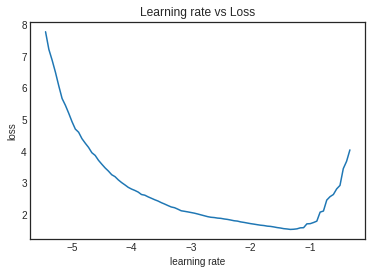

In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

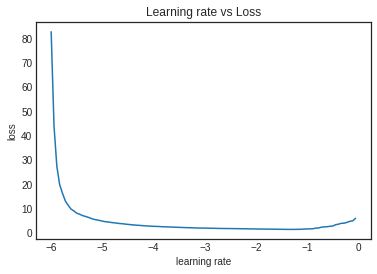

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2.98)

0.0010471285480508996

In [ ]:
pow(10,-2) #0.000 001

0.01

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

47/47 [==============================] - 15s 275ms/step - loss: 95.3779 - get_f1: 0.8245
loss : 95.3779
get_f1 : 0.8245


## lr=0.01 - binary

In [ ]:
learning_rate = 0.01
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1792)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=8, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/8
93/93 [==============================] - 50s 378ms/step - loss: 1.8143 - get_f1: 0.7603 - val_loss: 2.0904 - val_get_f1: 0.8369
Epoch 2/8
93/93 [==============================] - 32s 343ms/step - loss: 1.4731 - get_f1: 0.7959 - val_loss: 0.8367 - val_get_f1: 0.7531
Epoch 3/8
93/93 [==============================] - 32s 340ms/step - loss: 1.2947 - get_f1: 0.8163 - val_loss: 0.7021 - val_get_f1: 0.9003
Epoch 4/8
93/93 [==============================] - 32s 343ms/step - loss: 1.2562 - get_f1: 0.8296 - val_loss: 0.6128 - val_get_f1: 0.9115
Epoch 5/8
93/93 [==============================] - 32s 341ms/step - loss: 1.3504 - get_f1: 0.8256 - val_loss: 1.1339 - val_get_f1: 0.8843
Epoch 6/8
93/93 [==============================] - 32s 341ms/step - loss: 1.5322 - get_f1: 0.8183 - val_loss: 1.0813 - val_get_f1: 0.7036
Epoch 7/8
93/93 [==============================] - 32s 341ms/step - loss: 1.3717 - get_f1: 0.8252 - val_loss: 0.9630 - val_get_f1: 0.9020
Epoch 8/8
93/93 [=================

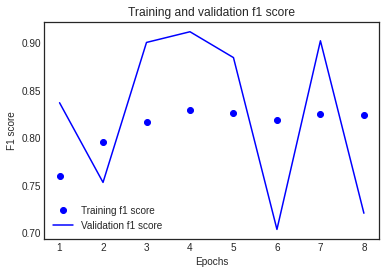

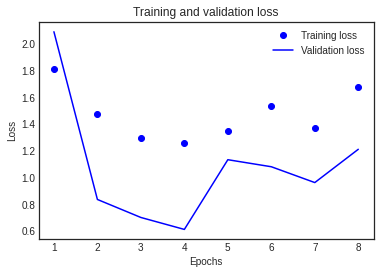

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_4 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 1792)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=4, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/4
124/124 [==============================] - 47s 260ms/step - loss: 1.8629 - get_f1: 0.7686
Epoch 2/4
124/124 [==============================] - 32s 259ms/step - loss: 1.1099 - get_f1: 0.8335
Epoch 3/4
124/124 [==============================] - 32s 256ms/step - loss: 1.6211 - get_f1: 0.8000
Epoch 4/4
124/124 [==============================] - 32s 258ms/step - loss: 1.3451 - get_f1: 0.8243
Training time: 158.46983575820923s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

124/124 [==============================] - 34s 256ms/step - loss: 0.6831 - get_f1: 0.8973
train:  [0.6831241250038147, 0.8972991108894348]
31/31 [==============================] - 8s 251ms/step - loss: 0.7389 - get_f1: 0.9044
test:  [0.7389488220214844, 0.9044345617294312]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.8389815838239907
AP macro:  0.8389815838239907 

f1 micro:  0.8565656565656565
f1 macro:  0.8013329263329263
f1 binary:  0.906084656084656 

precision micro:  0.8565656565656565
precision macro:  0.8838298525798526
precision binary:  0.8415233415233415 

recall micro:  0.8565656565656565
recall macro:  0.7697972681241905
recall binary:  0.9813753581661891 

accuracy:  0.8565656565656565
log_loss:  nan
brier_score_loss:  0.14343434343434344


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.56      0.70       292
           1       0.84      0.98      0.91       698

    accuracy                           0.86       990
   macro avg       0.88      0.77      0.80       990
weighted avg       0.87      0.86      0.84       990



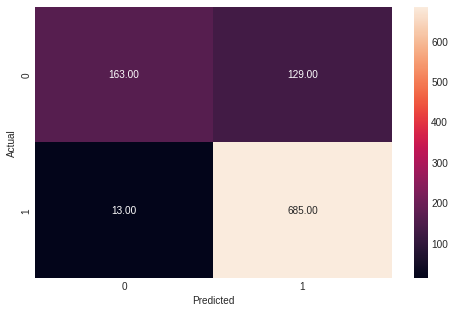

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 - binary

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

71696384/71686520 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d (Globa  (None, 1792)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
#with tf.device("/device:GPU:0"):
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
93/93 [==============================] - 931s 10s/step - loss: 1.1553 - get_f1: 0.7466 - val_loss: 0.4341 - val_get_f1: 0.8719
Epoch 2/10
93/93 [==============================] - 909s 10s/step - loss: 0.8099 - get_f1: 0.7962 - val_loss: 0.5560 - val_get_f1: 0.8765
Epoch 3/10
93/93 [==============================] - 909s 10s/step - loss: 0.7043 - get_f1: 0.8215 - val_loss: 0.3908 - val_get_f1: 0.8999
Epoch 4/10
93/93 [==============================] - 915s 10s/step - loss: 0.6275 - get_f1: 0.8353 - val_loss: 0.3803 - val_get_f1: 0.8828
Epoch 5/10
93/93 [==============================] - 911s 10s/step - loss: 0.6144 - get_f1: 0.8404 - val_loss: 0.5374 - val_get_f1: 0.8833
Epoch 6/10
93/93 [==============================] - 913s 10s/step - loss: 0.5905 - get_f1: 0.8495 - val_loss: 0.3735 - val_get_f1: 0.9069
Epoch 7/10
93/93 [==============================] - 909s 10s/step - loss: 0.5242 - get_f1: 0.8570 - val_loss: 0.3749 - val_get_f1: 0.9074
Epoch 8/10
93/93 [================

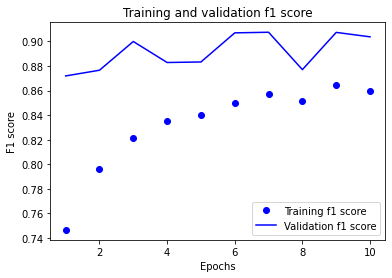

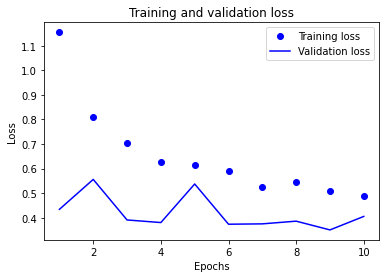

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1792)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
#with tf.device("/device:GPU:0"):
start_time = time.time()

history = model.fit(X_train, y_train, epochs=3, batch_size=batch_size)

end_time = time.time()
print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
124/124 [==============================] - 943s 7s/step - loss: 0.9709 - get_f1: 0.7766
Epoch 2/3
124/124 [==============================] - 938s 8s/step - loss: 0.7445 - get_f1: 0.8221
Epoch 3/3
124/124 [==============================] - 959s 8s/step - loss: 0.6397 - get_f1: 0.8349
Training time: 2863.7855491638184s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.856516978403096
AP macro:  0.856516978403096 

f1 micro:  0.8494949494949496
f1 macro:  0.8096377425986365
f1 binary:  0.8967428967428969 

precision micro:  0.8494949494949495
precision macro:  0.8301465552664018
precision binary:  0.8684563758389262 

recall micro:  0.8494949494949495
recall macro:  0.7956588295325195
recall binary:  0.9269340974212035 

accuracy:  0.8494949494949495
log_loss:  0.36748767100366286
brier_score_loss:  0.1505050505050505


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       292
           1       0.87      0.93      0.90       698

    accuracy                           0.85       990
   macro avg       0.83      0.80      0.81       990
weighted avg       0.85      0.85      0.85       990



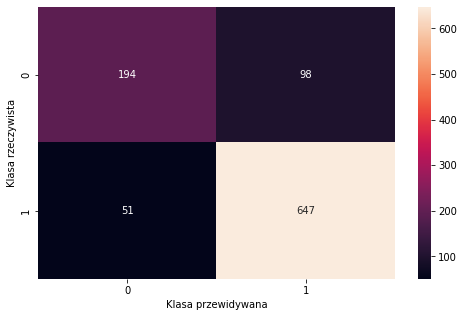

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

## lr=0.001 & do=0.2 - SELECTED

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1792)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1792)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
93/93 [==============================] - 47s 364ms/step - loss: 0.8695 - get_f1: 0.7469 - val_loss: 0.5034 - val_get_f1: 0.8612
Epoch 2/10
93/93 [==============================] - 31s 338ms/step - loss: 0.6092 - get_f1: 0.8189 - val_loss: 0.3969 - val_get_f1: 0.8977
Epoch 3/10
93/93 [==============================] - 32s 346ms/step - loss: 0.5515 - get_f1: 0.8466 - val_loss: 0.3922 - val_get_f1: 0.8819
Epoch 4/10
93/93 [==============================] - 32s 348ms/step - loss: 0.5123 - get_f1: 0.8534 - val_loss: 0.4366 - val_get_f1: 0.8913
Epoch 5/10
93/93 [==============================] - 32s 345ms/step - loss: 0.4944 - get_f1: 0.8658 - val_loss: 0.3496 - val_get_f1: 0.9087
Epoch 6/10
93/93 [==============================] - 32s 345ms/step - loss: 0.4476 - get_f1: 0.8766 - val_loss: 0.3371 - val_get_f1: 0.9165
Epoch 7/10
93/93 [==============================] - 32s 345ms/step - loss: 0.4506 - get_f1: 0.8691 - val_loss: 0.4105 - val_get_f1: 0.9001
Epoch 8/10
93/93 [=========

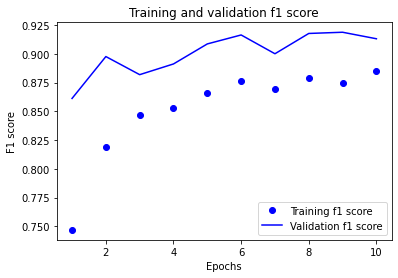

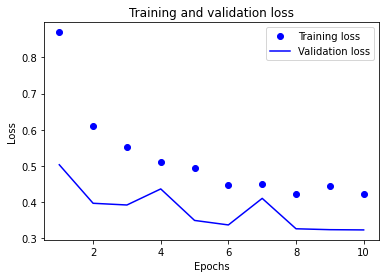

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB4(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

71696384/71686520 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 12, 1792)      17673823  
                                                                 
 global_max_pooling2d (Globa  (None, 1792)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 1,793
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=6, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.') #155s

Epoch 1/6
124/124 [==============================] - 56s 251ms/step - loss: 0.7443 - get_f1: 0.7839
Epoch 2/6
124/124 [==============================] - 30s 243ms/step - loss: 0.5697 - get_f1: 0.8302
Epoch 3/6
124/124 [==============================] - 30s 246ms/step - loss: 0.5223 - get_f1: 0.8521
Epoch 4/6
124/124 [==============================] - 31s 248ms/step - loss: 0.4774 - get_f1: 0.8622
Epoch 5/6
124/124 [==============================] - 31s 249ms/step - loss: 0.4538 - get_f1: 0.8648
Epoch 6/6
124/124 [==============================] - 31s 250ms/step - loss: 0.4448 - get_f1: 0.8718
Training time: 214.9662048816681s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

124/124 [==============================] - 33s 244ms/step - loss: 0.3168 - get_f1: 0.9165
train:  [0.3168022930622101, 0.9165117740631104]
31/31 [==============================] - 8s 243ms/step - loss: 0.3444 - get_f1: 0.9121
test:  [0.3443799614906311, 0.9121077060699463]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.8684640858898135
AP macro:  0.8684640858898135 

f1 micro:  0.8727272727272727
f1 macro:  0.8361004682843762
f1 binary:  0.9135802469135802 

precision micro:  0.8727272727272727
precision macro:  0.8685926773455377
precision binary:  0.8763157894736842 

recall micro:  0.8727272727272727
recall macro:  0.816118459787259
recall binary:  0.9541547277936963 

accuracy:  0.8727272727272727
log_loss:  0.3443799327371637
brier_score_loss:  0.12727272727272726


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       292
           1       0.88      0.95      0.91       698

    accuracy                           0.87       990
   macro avg       0.87      0.82      0.84       990
weighted avg       0.87      0.87      0.87       990



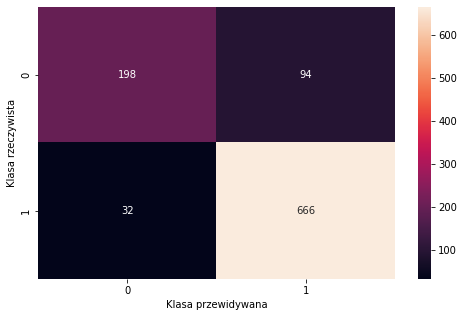

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
model.save('drive/MyDrive/mgr/saved_models/6m_en4_img_imbalanced_rm')

In [ ]:
test_model = models.load_model('drive/MyDrive/mgr/saved_models/6m_en4_img_imbalanced_rm', custom_objects={"get_f1": get_f1})

In [ ]:
print(classification_report(y_test, test_model.predict(X_test)>=0.5))

              precision    recall  f1-score   support

           0       0.86      0.68      0.76       292
           1       0.88      0.95      0.91       698

    accuracy                           0.87       990
   macro avg       0.87      0.82      0.84       990
weighted avg       0.87      0.87      0.87       990



# DenseNet201

## Find optimal learning rate

In [ ]:
# bez danych walidacyjnych:
#with tf.device("/device:GPU:0"):
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-6, maximum_lr=1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[get_f1])

In [ ]:
#with tf.device("/device:GPU:0"):
    #history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=1, batch_size=bs, validation_data=(X_test, to_categorical(y_test, num_classes=2)), callbacks=[lr_finder])
history = model.fit(X_train, y_train, epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00000114 
109/109 [==============================] - 1188s 11s/step - loss: 9.2512 - get_f1: 0.6792


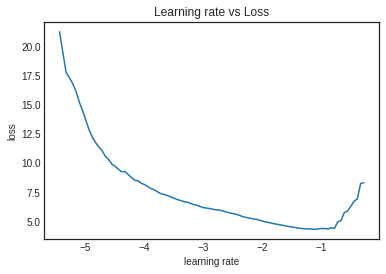

In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

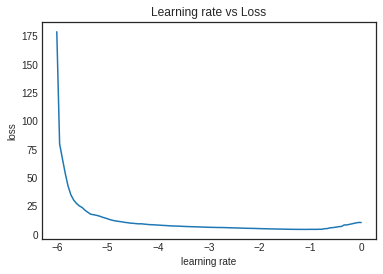

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2.98)

0.0010471285480508996

In [ ]:
pow(10,-2) #0.000 001

0.01

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

47/47 [==============================] - 510s 11s/step - loss: 28.0299 - get_f1: 0.8296
loss : 28.0299
get_f1 : 0.8296


## lr=0.0001 - binary 

In [ ]:
learning_rate = 0.0001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
#with tf.device("/device:GPU:0"):
history = model.fit(X_train, y_train, epochs=13, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/13
93/93 [==============================] - 42s 341ms/step - loss: 3.0778 - get_f1: 0.6925 - val_loss: 1.3722 - val_get_f1: 0.8053
Epoch 2/13
93/93 [==============================] - 27s 296ms/step - loss: 2.7936 - get_f1: 0.7006 - val_loss: 1.2787 - val_get_f1: 0.8273
Epoch 3/13
93/93 [==============================] - 27s 293ms/step - loss: 2.5441 - get_f1: 0.7149 - val_loss: 0.9852 - val_get_f1: 0.8352
Epoch 4/13
93/93 [==============================] - 28s 297ms/step - loss: 2.2348 - get_f1: 0.7251 - val_loss: 1.0459 - val_get_f1: 0.8436
Epoch 5/13
93/93 [==============================] - 27s 295ms/step - loss: 1.9315 - get_f1: 0.7407 - val_loss: 0.8120 - val_get_f1: 0.8545
Epoch 6/13
93/93 [==============================] - 27s 294ms/step - loss: 2.0282 - get_f1: 0.7361 - val_loss: 0.6972 - val_get_f1: 0.8598
Epoch 7/13
93/93 [==============================] - 28s 297ms/step - loss: 1.8571 - get_f1: 0.7454 - val_loss: 0.7617 - val_get_f1: 0.8657
Epoch 8/13
93/93 [=========

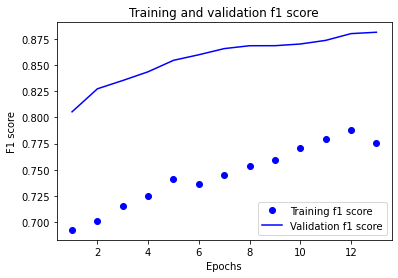

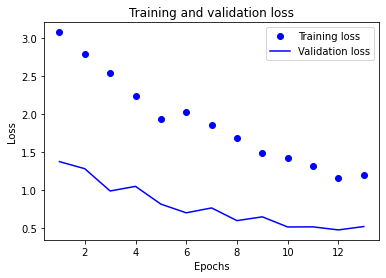

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_2 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=6, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/6
124/124 [==============================] - 49s 258ms/step - loss: 3.7946 - get_f1: 0.6013
Epoch 2/6
124/124 [==============================] - 28s 223ms/step - loss: 2.7744 - get_f1: 0.7103
Epoch 3/6
124/124 [==============================] - 28s 223ms/step - loss: 2.5140 - get_f1: 0.7199
Epoch 4/6
124/124 [==============================] - 28s 224ms/step - loss: 2.2527 - get_f1: 0.7261
Epoch 5/6
124/124 [==============================] - 28s 223ms/step - loss: 2.0815 - get_f1: 0.7429
Epoch 6/6
124/124 [==============================] - 28s 222ms/step - loss: 1.9430 - get_f1: 0.7430
Training time: 219.85579752922058s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

124/124 [==============================] - 32s 232ms/step - loss: 0.9031 - get_f1: 0.8544
train:  [0.9030510783195496, 0.8543891310691833]
31/31 [==============================] - 7s 226ms/step - loss: 0.8891 - get_f1: 0.8562
test:  [0.8890911936759949, 0.8562085628509521]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.7612393273711325
AP macro:  0.7612393273711325 

f1 micro:  0.7717171717171717
f1 macro:  0.6334750899357181
f1 binary:  0.8585732165206508 

precision micro:  0.7717171717171717
precision macro:  0.8144444444444445
precision binary:  0.7622222222222222 

recall micro:  0.7717171717171717
recall macro:  0.6249656552969345
recall binary:  0.9828080229226361 

accuracy:  0.7717171717171717
log_loss:  0.8890904386187299
brier_score_loss:  0.22828282828282828


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.27      0.41       292
           1       0.76      0.98      0.86       698

    accuracy                           0.77       990
   macro avg       0.81      0.62      0.63       990
weighted avg       0.79      0.77      0.73       990



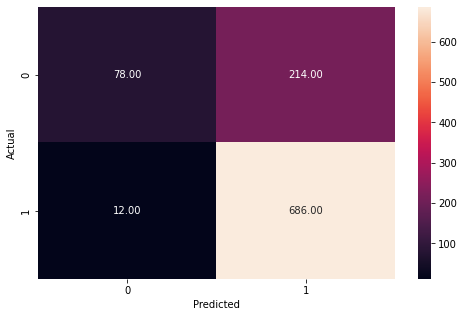

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 - binary - SELECTED

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1920)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/5
93/93 [==============================] - 46s 374ms/step - loss: 2.4123 - get_f1: 0.7472 - val_loss: 0.9250 - val_get_f1: 0.8631
Epoch 2/5
93/93 [==============================] - 27s 295ms/step - loss: 1.3529 - get_f1: 0.7951 - val_loss: 0.4549 - val_get_f1: 0.8695
Epoch 3/5
93/93 [==============================] - 27s 296ms/step - loss: 0.9248 - get_f1: 0.8114 - val_loss: 0.4347 - val_get_f1: 0.8972
Epoch 4/5
93/93 [==============================] - 27s 295ms/step - loss: 0.7181 - get_f1: 0.8371 - val_loss: 0.3754 - val_get_f1: 0.9006
Epoch 5/5
93/93 [==============================] - 27s 295ms/step - loss: 0.6457 - get_f1: 0.8361 - val_loss: 0.4449 - val_get_f1: 0.8348


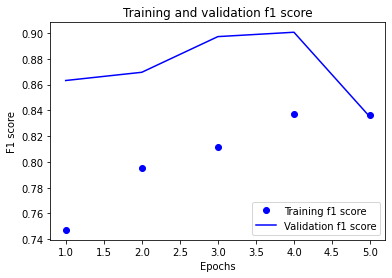

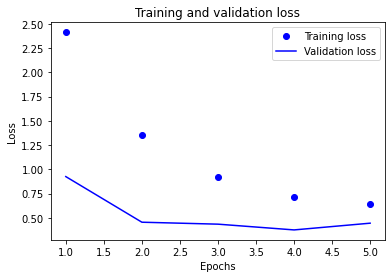

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

74850304/74836368 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d (Globa  (None, 1920)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=4, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/4
124/124 [==============================] - 56s 242ms/step - loss: 2.2300 - get_f1: 0.7359
Epoch 2/4
124/124 [==============================] - 26s 213ms/step - loss: 0.9762 - get_f1: 0.8085
Epoch 3/4
124/124 [==============================] - 27s 215ms/step - loss: 0.7756 - get_f1: 0.8261
Epoch 4/4
124/124 [==============================] - 27s 217ms/step - loss: 0.6452 - get_f1: 0.8377
Training time: 152.85807824134827s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

124/124 [==============================] - 30s 217ms/step - loss: 0.3295 - get_f1: 0.9099
train:  [0.3294840455055237, 0.9098652005195618]
31/31 [==============================] - 7s 215ms/step - loss: 0.3384 - get_f1: 0.9051
test:  [0.3384143114089966, 0.9051238298416138]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.8713075242006516
AP macro:  0.8713075242006516 

f1 micro:  0.8656565656565657
f1 macro:  0.8316401879615125
f1 binary:  0.9073170731707316 

precision micro:  0.8656565656565657
precision macro:  0.8487699840717362
precision binary:  0.8833107191316146 

recall micro:  0.8656565656565657
recall macro:  0.819072104250893
recall binary:  0.9326647564469914 

accuracy:  0.8656565656565657
log_loss:  0.338414314266676
brier_score_loss:  0.13434343434343435


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76       292
           1       0.88      0.93      0.91       698

    accuracy                           0.87       990
   macro avg       0.85      0.82      0.83       990
weighted avg       0.86      0.87      0.86       990



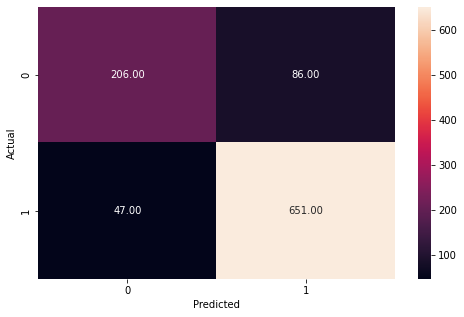

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model.save('drive/MyDrive/mgr/saved_models/2m_dn201_img_imbalanced')

In [ ]:
test_model = models.load_model('drive/MyDrive/mgr/saved_models/2m_dn201_img_imbalanced', custom_objects={"get_f1": get_f1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
y_pred_p = test_model.predict(X_test)
y_pred = y_pred_p>=0.5 

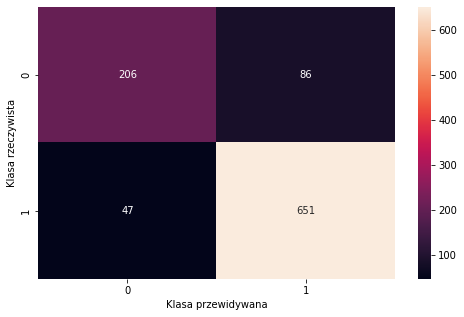

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

In [ ]:
print(classification_report(y_test, test_model.predict(X_test)>=0.5))

## lr=0.01 - binary 

In [ ]:
learning_rate = 0.01
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

74850304/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d (Globa  (None, 1920)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
#with tf.device("/device:GPU:0"):
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/5
93/93 [==============================] - 64s 418ms/step - loss: 3.0071 - get_f1: 0.7576 - val_loss: 0.8891 - val_get_f1: 0.7815
Epoch 2/5
93/93 [==============================] - 28s 297ms/step - loss: 1.7768 - get_f1: 0.8027 - val_loss: 0.8420 - val_get_f1: 0.9002
Epoch 3/5
93/93 [==============================] - 31s 332ms/step - loss: 1.5577 - get_f1: 0.8228 - val_loss: 0.9307 - val_get_f1: 0.8809
Epoch 4/5
93/93 [==============================] - 27s 293ms/step - loss: 1.8378 - get_f1: 0.8102 - val_loss: 0.9050 - val_get_f1: 0.8927
Epoch 5/5
93/93 [==============================] - 28s 299ms/step - loss: 2.2974 - get_f1: 0.8042 - val_loss: 0.5931 - val_get_f1: 0.9066


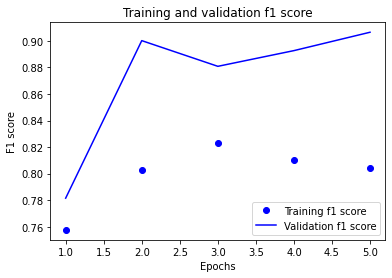

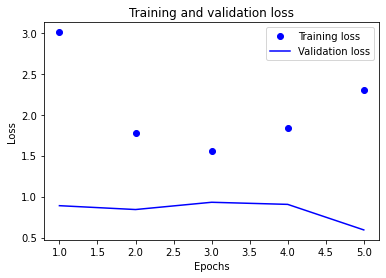

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 11, 1920)       18321984  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 1920)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
#with tf.device("/device:GPU:0"):
start_time = time.time()

history = model.fit(X_train, y_train, epochs=2, batch_size=batch_size)

end_time = time.time()
print(f'Training time: {end_time - start_time}s.')

Epoch 1/2
124/124 [==============================] - 44s 258ms/step - loss: 2.4156 - get_f1: 0.7808
Epoch 2/2
124/124 [==============================] - 27s 221ms/step - loss: 1.7913 - get_f1: 0.8049
Training time: 95.61260223388672s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

124/124 [==============================] - 31s 224ms/step - loss: 1.1675 - get_f1: 0.8848
train:  [1.1675201654434204, 0.8848316669464111]
31/31 [==============================] - 7s 218ms/step - loss: 1.2198 - get_f1: 0.8876
test:  [1.2198485136032104, 0.8876298666000366]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.8079166177194156
AP macro:  0.8079166177194156 

f1 micro:  0.8262626262626263
f1 macro:  0.7453703703703705
f1 binary:  0.888888888888889 

precision micro:  0.8262626262626263
precision macro:  0.8689915966386554
precision binary:  0.8094117647058824 

recall micro:  0.8262626262626263
recall macro:  0.7154394159437925
recall binary:  0.9856733524355301 

accuracy:  0.8262626262626263
log_loss:  nan
brier_score_loss:  0.17373737373737375


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.45      0.60       292
           1       0.81      0.99      0.89       698

    accuracy                           0.83       990
   macro avg       0.87      0.72      0.75       990
weighted avg       0.84      0.83      0.80       990



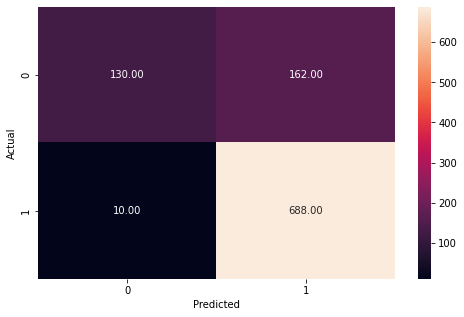

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# EfficientNet-B0

## Find optimal learning rate

In [ ]:
# bez danych walidacyjnych:
with tf.device("/device:GPU:0"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
input_shape

(224, 374, 3)

In [ ]:
bs=32

In [ ]:
lr_finder = LRFinder(X_train.shape[0], bs, minimum_lr=1e-6, maximum_lr=1,
                     lr_scale='exp',
                     # validation_data=(X_test, y_test),  # use the validation data for losses
                     validation_sample_rate=5,
                     verbose=True)

In [ ]:
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=1, batch_size=bs, validation_data=(X_test, to_categorical(y_test, num_classes=2)), callbacks=[lr_finder])
    #history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=1, batch_size=bs, callbacks=[lr_finder])


 - LRFinder: lr = 0.00000114 
109/109 [==============================] - 22s 151ms/step - loss: 6.9813 - get_f1: 0.5371 - val_loss: 188.8492 - val_get_f1: 0.3140


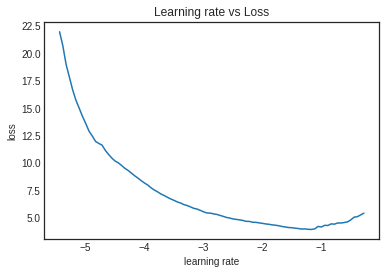

In [ ]:
lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

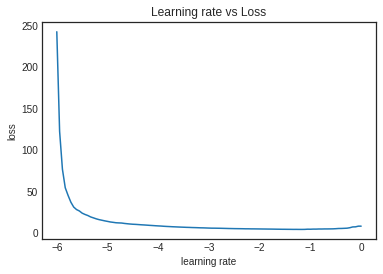

In [ ]:
lr_finder.plot_schedule()

In [ ]:
pow(10,-2.98)

0.0010471285480508996

In [ ]:
pow(10,-3.5) #0.000 001

0.00031622776601683794

In [ ]:
scores = model.evaluate(X_test, to_categorical(y_test, num_classes=2), batch_size=bs)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

47/47 [==============================] - 4s 95ms/step - loss: 188.8492 - get_f1: 0.3140
loss : 188.8492
get_f1 : 0.3140


## lr=0.0001

In [ ]:
learning_rate = 0.0001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
#model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=2)))

Epoch 1/10
93/93 [==============================] - 22s 176ms/step - loss: 2.5406 - get_f1: 0.5492 - val_loss: 1.1102 - val_get_f1: 0.6739
Epoch 2/10
93/93 [==============================] - 12s 127ms/step - loss: 1.9891 - get_f1: 0.6027 - val_loss: 0.8298 - val_get_f1: 0.7253
Epoch 3/10
93/93 [==============================] - 12s 128ms/step - loss: 1.6832 - get_f1: 0.6403 - val_loss: 0.7494 - val_get_f1: 0.7676
Epoch 4/10
93/93 [==============================] - 12s 128ms/step - loss: 1.5889 - get_f1: 0.6483 - val_loss: 0.6271 - val_get_f1: 0.7808
Epoch 5/10
93/93 [==============================] - 12s 129ms/step - loss: 1.5241 - get_f1: 0.6653 - val_loss: 0.6854 - val_get_f1: 0.7948
Epoch 6/10
93/93 [==============================] - 12s 129ms/step - loss: 1.4469 - get_f1: 0.6860 - val_loss: 0.5640 - val_get_f1: 0.8040
Epoch 7/10
93/93 [==============================] - 12s 129ms/step - loss: 1.3554 - get_f1: 0.6975 - val_loss: 0.5555 - val_get_f1: 0.8202
Epoch 8/10
93/93 [=========

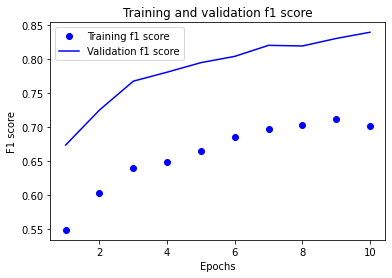

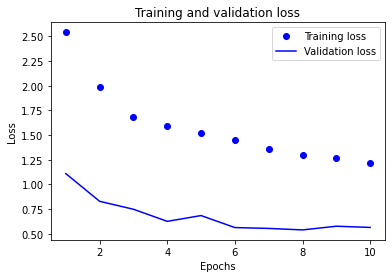

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
#model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()
  
  history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=7, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/7
109/109 [==============================] - 19s 97ms/step - loss: 1.9366 - get_f1: 0.6019
Epoch 2/7
109/109 [==============================] - 11s 98ms/step - loss: 1.6472 - get_f1: 0.6536
Epoch 3/7
109/109 [==============================] - 11s 98ms/step - loss: 1.5849 - get_f1: 0.6545
Epoch 4/7
109/109 [==============================] - 11s 98ms/step - loss: 1.3842 - get_f1: 0.6871
Epoch 5/7
109/109 [==============================] - 11s 98ms/step - loss: 1.3339 - get_f1: 0.6916
Epoch 6/7
109/109 [==============================] - 11s 98ms/step - loss: 1.3243 - get_f1: 0.6973
Epoch 7/7
109/109 [==============================] - 11s 98ms/step - loss: 1.2392 - get_f1: 0.7044
Training time: 91.35687065124512s.


In [ ]:
#y_pred = model.predict(X_test) 
y_pred = argmax(model.predict(X_test), axis=1).numpy()
accuracy_score(y_test, y_pred) #83

0.8134680134680135

In [ ]:
model.evaluate(X_train, to_categorical(y_train, num_classes=2))

109/109 [==============================] - 12s 98ms/step - loss: 0.5976 - get_f1: 0.8095


[0.5975818037986755, 0.809537410736084]

In [ ]:
model.evaluate(X_test, to_categorical(y_test, num_classes=2))

47/47 [==============================] - 5s 97ms/step - loss: 0.6036 - get_f1: 0.8119


[0.6036311388015747, 0.8119372725486755]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.53      0.63       437
           1       0.83      0.93      0.88      1048

    accuracy                           0.81      1485
   macro avg       0.80      0.73      0.75      1485
weighted avg       0.81      0.81      0.80      1485



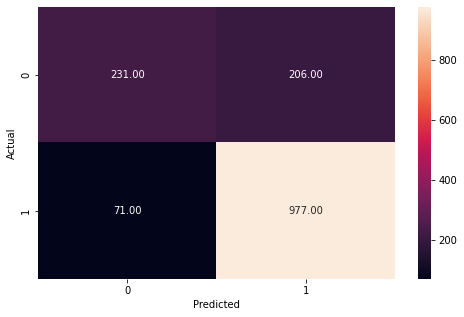

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
#model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=2)))

Epoch 1/10
93/93 [==============================] - 21s 157ms/step - loss: 1.6745 - get_f1: 0.6713 - val_loss: 0.6398 - val_get_f1: 0.8132
Epoch 2/10
93/93 [==============================] - 13s 135ms/step - loss: 1.2295 - get_f1: 0.7172 - val_loss: 0.5176 - val_get_f1: 0.8273
Epoch 3/10
93/93 [==============================] - 12s 134ms/step - loss: 0.9423 - get_f1: 0.7457 - val_loss: 0.4718 - val_get_f1: 0.8628
Epoch 4/10
93/93 [==============================] - 12s 134ms/step - loss: 0.8058 - get_f1: 0.7693 - val_loss: 0.4588 - val_get_f1: 0.8608
Epoch 5/10
93/93 [==============================] - 14s 156ms/step - loss: 0.6685 - get_f1: 0.7980 - val_loss: 0.5809 - val_get_f1: 0.8274
Epoch 6/10
93/93 [==============================] - 12s 133ms/step - loss: 0.6254 - get_f1: 0.7980 - val_loss: 0.4024 - val_get_f1: 0.8426
Epoch 7/10
93/93 [==============================] - 13s 135ms/step - loss: 0.6347 - get_f1: 0.7904 - val_loss: 0.4951 - val_get_f1: 0.7970
Epoch 8/10
93/93 [=========

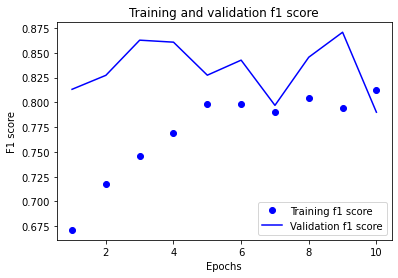

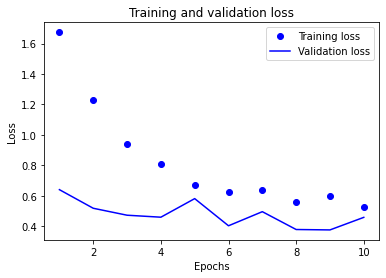

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
#model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
#with tf.device("/device:GPU:0"):
start_time = time.time()

history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=3, batch_size=batch_size)

end_time = time.time()
print(f'Training time: {end_time - start_time}s.')

Epoch 1/3
109/109 [==============================] - 17s 100ms/step - loss: 1.5037 - get_f1: 0.6864
Epoch 2/3
109/109 [==============================] - 11s 101ms/step - loss: 1.0380 - get_f1: 0.7468
Epoch 3/3
109/109 [==============================] - 11s 101ms/step - loss: 0.9212 - get_f1: 0.7563
Training time: 47.877264738082886s.


In [ ]:
#y_pred = model.predict(X_test)
y_pred = argmax(model.predict(X_test), axis=1).numpy()
accuracy_score(y_test, y_pred)

0.8518518518518519

In [ ]:
print(model.evaluate(X_train, to_categorical(y_train, num_classes=2)))

109/109 [==============================] - 12s 98ms/step - loss: 0.4833 - get_f1: 0.8540
[0.4832761287689209, 0.8539754748344421]


In [ ]:
model.evaluate(X_test, to_categorical(y_test, num_classes=2))

47/47 [==============================] - 5s 99ms/step - loss: 0.5199 - get_f1: 0.8508


[0.5198890566825867, 0.8508080244064331]

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.63      0.71       437
           1       0.86      0.94      0.90      1048

    accuracy                           0.85      1485
   macro avg       0.84      0.79      0.81      1485
weighted avg       0.85      0.85      0.85      1485



In [ ]:
print(average_precision_score(y_test, y_pred)) 

0.8508714089045673


In [ ]:
print(f1_score(y_test, y_pred)) 
print(f1_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='macro'))

0.9
0.8518518518518519
0.8071428571428572


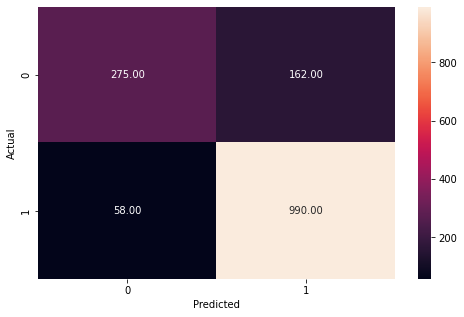

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## lr=0.001 - binary - SELECTED

In [ ]:
learning_rate = 0.001
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d_3 (Glo  (None, 1280)             0         
 balMaxPooling2D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
93/93 [==============================] - 21s 151ms/step - loss: 1.4233 - get_f1: 0.7360 - val_loss: 0.5671 - val_get_f1: 0.8784
Epoch 2/10
93/93 [==============================] - 12s 134ms/step - loss: 0.9443 - get_f1: 0.7969 - val_loss: 0.4625 - val_get_f1: 0.8936
Epoch 3/10
93/93 [==============================] - 13s 136ms/step - loss: 0.7943 - get_f1: 0.8268 - val_loss: 0.5250 - val_get_f1: 0.8926
Epoch 4/10
93/93 [==============================] - 13s 136ms/step - loss: 0.7171 - get_f1: 0.8253 - val_loss: 0.3874 - val_get_f1: 0.9022
Epoch 5/10
93/93 [==============================] - 13s 138ms/step - loss: 0.6457 - get_f1: 0.8427 - val_loss: 0.5415 - val_get_f1: 0.8036
Epoch 6/10
93/93 [==============================] - 13s 135ms/step - loss: 0.6089 - get_f1: 0.8462 - val_loss: 0.3677 - val_get_f1: 0.9058
Epoch 7/10
93/93 [==============================] - 12s 135ms/step - loss: 0.5618 - get_f1: 0.8490 - val_loss: 0.3661 - val_get_f1: 0.9040
Epoch 8/10
93/93 [=========

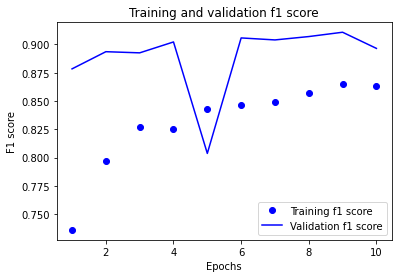

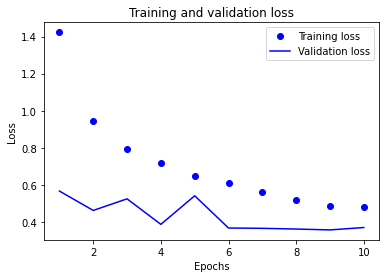

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[get_f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 12, 1280)      4049571   
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()

  history = model.fit(X_train, y_train, epochs=4, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/4
124/124 [==============================] - 22s 108ms/step - loss: 1.2260 - get_f1: 0.7636
Epoch 2/4
124/124 [==============================] - 13s 102ms/step - loss: 0.8522 - get_f1: 0.8110
Epoch 3/4
124/124 [==============================] - 13s 102ms/step - loss: 0.7425 - get_f1: 0.8314
Epoch 4/4
124/124 [==============================] - 12s 101ms/step - loss: 0.6302 - get_f1: 0.8442
Training time: 88.89399838447571s.


In [ ]:
y_pred_p = model.predict(X_test)
y_pred = y_pred_p>=0.5 

In [ ]:
with tf.device("/device:GPU:0"):
  print('train: ', model.evaluate(X_train, y_train))
  print('test: ', model.evaluate(X_test, y_test))

124/124 [==============================] - 14s 100ms/step - loss: 0.4031 - get_f1: 0.9033
train:  [0.40307292342185974, 0.9033250212669373]
31/31 [==============================] - 3s 107ms/step - loss: 0.4226 - get_f1: 0.9042
test:  [0.422622412443161, 0.9042450189590454]


In [ ]:
y_proba = predict_prob(y_pred_p)

In [ ]:
print_metrics(y_test, y_pred, y_proba)

AP micro:  0.8463822345263465
AP macro:  0.8463822345263465 

f1 micro:  0.8575757575757575
f1 macro:  0.808544518645616
f1 binary:  0.9054325955734407 

precision micro:  0.8575757575757575
precision macro:  0.8672233566549952
precision binary:  0.8511979823455234 

recall micro:  0.8575757575757575
recall macro:  0.7814695607803117
recall binary:  0.9670487106017192 

accuracy:  0.8575757575757575
log_loss:  0.4226224372715065
brier_score_loss:  0.14242424242424243


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.60      0.71       292
           1       0.85      0.97      0.91       698

    accuracy                           0.86       990
   macro avg       0.87      0.78      0.81       990
weighted avg       0.86      0.86      0.85       990



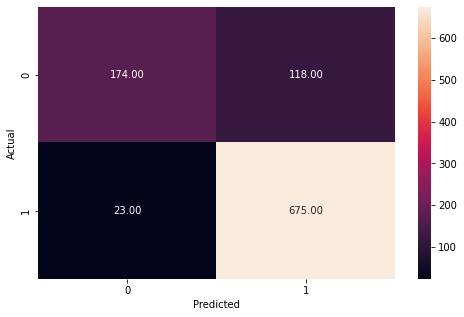

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
model.save('drive/MyDrive/mgr/saved_models/1m_ef0_img_imbalanced')

In [ ]:
test_model = models.load_model('drive/MyDrive/mgr/saved_models/1m_ef0_img_imbalanced', custom_objects={"get_f1": get_f1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, stratify=y)

In [ ]:
y_pred_p = test_model.predict(X_test)
y_pred = y_pred_p>=0.5 

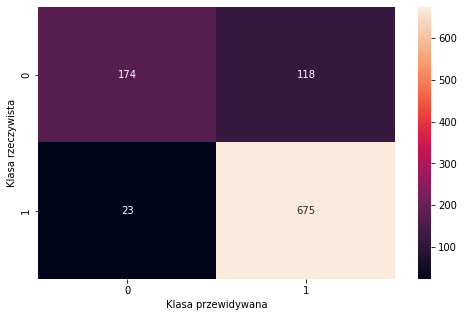

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.0f')
plt.ylabel('Klasa rzeczywista')
plt.xlabel('Klasa przewidywana')
plt.show(block=False)

## lr=0.0003


In [ ]:
learning_rate = 0.0003
batch_size = 32

### z danymi walidacyjnymi

In [ ]:
# z danymi walidacyjnymi:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
#model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
with tf.device("/device:GPU:0"):
    history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=15, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val, num_classes=2)))

Epoch 1/15
93/93 [==============================] - 37s 183ms/step - loss: 1.8298 - get_f1: 0.6245 - val_loss: 0.7891 - val_get_f1: 0.7749
Epoch 2/15
93/93 [==============================] - 12s 134ms/step - loss: 1.5453 - get_f1: 0.6617 - val_loss: 0.9022 - val_get_f1: 0.7759
Epoch 3/15
93/93 [==============================] - 12s 134ms/step - loss: 1.2644 - get_f1: 0.7036 - val_loss: 0.5478 - val_get_f1: 0.8161
Epoch 4/15
93/93 [==============================] - 12s 133ms/step - loss: 1.1762 - get_f1: 0.7220 - val_loss: 0.5266 - val_get_f1: 0.8396
Epoch 5/15
93/93 [==============================] - 12s 132ms/step - loss: 1.0867 - get_f1: 0.7158 - val_loss: 0.5362 - val_get_f1: 0.8344
Epoch 6/15
93/93 [==============================] - 12s 132ms/step - loss: 0.9791 - get_f1: 0.7459 - val_loss: 0.4796 - val_get_f1: 0.8364
Epoch 7/15
93/93 [==============================] - 12s 133ms/step - loss: 0.9094 - get_f1: 0.7559 - val_loss: 0.4450 - val_get_f1: 0.8486
Epoch 8/15
93/93 [=========

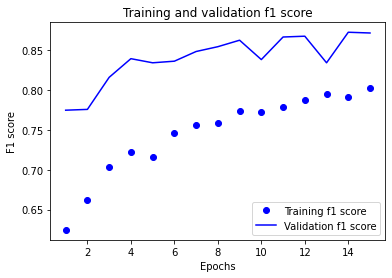

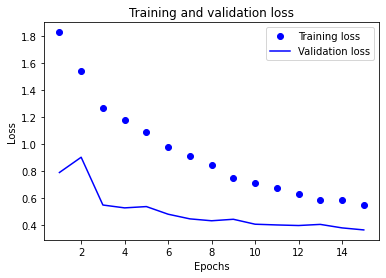

In [ ]:
f1 = history.history['get_f1']
val_f1 = history.history['val_get_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(1, len(f1)+1)

plt.plot(epochs_x, f1, 'bo', label='Training f1 score')
plt.plot(epochs_x, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
#plt.title('Training and validation accuracy')
#plt.ylabel('Accuracy')
plt.ylabel('F1 score')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### bez danych walidacyjnych

In [ ]:
#X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
#X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42, test_size=0.25)
#X_train = np.concatenate((X_train, X_val), axis=0)
#y_train = np.concatenate((y_train, y_val), axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [ ]:
input_shape = X_train[0].shape # (224, 374, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
#model.summary()
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=[get_f1])

In [ ]:
with tf.device("/device:GPU:0"):
  start_time = time.time()
  
  history = model.fit(X_train, to_categorical(y_train, num_classes=2), epochs=8, batch_size=batch_size)

  end_time = time.time()
  print(f'Training time: {end_time - start_time}s.')

Epoch 1/8
109/109 [==============================] - 18s 106ms/step - loss: 1.9036 - get_f1: 0.6210
Epoch 2/8
109/109 [==============================] - 11s 101ms/step - loss: 1.4898 - get_f1: 0.6826
Epoch 3/8
109/109 [==============================] - 11s 101ms/step - loss: 1.3544 - get_f1: 0.7044
Epoch 4/8
109/109 [==============================] - 11s 100ms/step - loss: 1.0810 - get_f1: 0.7315
Epoch 5/8
109/109 [==============================] - 11s 100ms/step - loss: 1.0445 - get_f1: 0.7425
Epoch 6/8
109/109 [==============================] - 11s 99ms/step - loss: 0.9566 - get_f1: 0.7436
Epoch 7/8
109/109 [==============================] - 11s 99ms/step - loss: 0.9220 - get_f1: 0.7515
Epoch 8/8
109/109 [==============================] - 11s 99ms/step - loss: 0.7750 - get_f1: 0.7751
Training time: 148.67627787590027s.


In [ ]:
#y_pred = model.predict(X_test) 
y_pred = argmax(model.predict(X_test), axis=1).numpy()
accuracy_score(y_test, y_pred) #83

0.8525252525252526

In [ ]:
model.evaluate(X_train, to_categorical(y_train, num_classes=2))

109/109 [==============================] - 12s 99ms/step - loss: 0.4898 - get_f1: 0.8457


[0.489783376455307, 0.8456612825393677]

In [ ]:
model.evaluate(X_test, to_categorical(y_test, num_classes=2))

47/47 [==============================] - 5s 98ms/step - loss: 0.5058 - get_f1: 0.8534


[0.5057529211044312, 0.8534164428710938]

In [ ]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.59      0.70       437
           1       0.85      0.96      0.90      1048

    accuracy                           0.85      1485
   macro avg       0.86      0.78      0.80      1485
weighted avg       0.85      0.85      0.84      1485



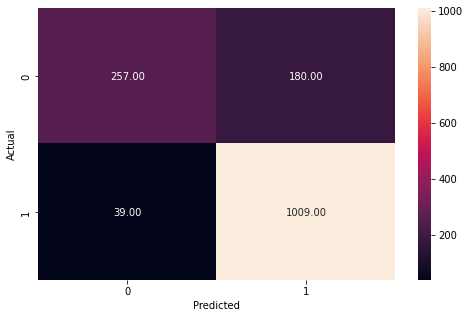

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cmn = cm.astype('float')
cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)